In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk

subj_id = "2069"
path = f"/raid/decaro/datasets/processed/AVLStudy/SUBJ_{subj_id}/SUBJ_{subj_id}_ALL_SCENARIOS.csv"
df = pd.read_csv(path)
df["Slider_value"] /= 1024

In [ ]:
scenario_id = 5
for x in range(scenario_id, scenario_id+1):
    scenario_df = df[df["ScenarioID"] == x]
    # scenario_df['median']= scenario_df['EDA_Clean'].rolling(100).median()
    # scenario_df['std'] = scenario_df['EDA_Clean'].rolling(100).std()

    # #filter setup
    # scenario_df = scenario_df[(scenario_df.EDA_Clean <= scenario_df['median']+3*scenario_df['std']) & (scenario_df.EDA_Clean >= scenario_df['median']-3*scenario_df['std'])]
    scenario_df.iloc[50:].plot(x="Time", y=["EDA_Tonic", "EDA_Phasic"], figsize=(20, 10))
    # scenario_df.plot(x="Time", y=["ECG_Rate"], figsize=(20, 10))
    # scenario_df.plot(x="Time", y=["Slider_value"], figsize=(20, 10))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.gca()
sns.kdeplot(data=df[df["ScenarioID"] > 2], x="Slider_value", common_norm=False, alpha=.5, ax=ax)
ax.set_title("Subject " + subj_id)
plt.show()


# ESN Testing

In [ ]:
from training.dataset import AVLDataset
from training.config import get_analysis, get_exp_dir
import torch
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
subj_id = "1042"
classification = True
exp_dir = get_exp_dir(subj_id, "ridge", classification)
analysis = get_analysis("retraining", exp_dir, "min")
trial = analysis.get_best_trial(metric="eval_loss", mode="min")
config = trial.config
res_path = analysis.get_best_checkpoint(
    trial, metric="eval_loss", mode="min", return_path=True
)
model = torch.load(os.path.join(res_path, "model.pkl"))
dataset = AVLDataset(split="all", **config["data"])

for i in range(len(dataset)):
    x, y = dataset[i]
    y_pred = torch.clamp(F.linear(model["reservoir"](x), model["readout"]), 0, 1)
    if classification:
        y_pred = torch.round(y_pred)
    pred_df = pd.DataFrame(
        {
            "time": np.arange(len(y_pred)),
            "pred": y_pred.squeeze().detach().cpu().numpy(),
            "true": y.squeeze().detach().cpu().numpy(),
            "EDA_Tonic": x[..., 0].squeeze().detach().cpu().numpy(),
            "EDA_Phasic": x[..., 1].squeeze().detach().cpu().numpy(),
        }
    )
    pred_df.plot(x="time", y=["pred", "true"])#, "EDA_Tonic", "EDA_Phasic"])

# Stress Parameters

```python
    {
        4022: 0.08, 100
        4396: 0.15, 300
        1018: 0.08, 300
        4181: 0.20, 300
        4235: 1.00, 100
        4392: 1.25, 100
    }
```

In [1]:
from training.dataset import AVLDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

subj_id = "4392"
baseline_path = f"/raid/decaro/datasets/processed/AVLStudy/SUBJ_{subj_id}/SUBJ_{subj_id}_SCEN_00_MODE_FreeDriving.csv"
baseline = pd.read_csv(baseline_path)
baseline["Slider_value"] /= 1024
dataset = AVLDataset(subj_id, "all", ["EDA_Clean", "EDA_Tonic", "EDA_Phasic"], "baseline", True)

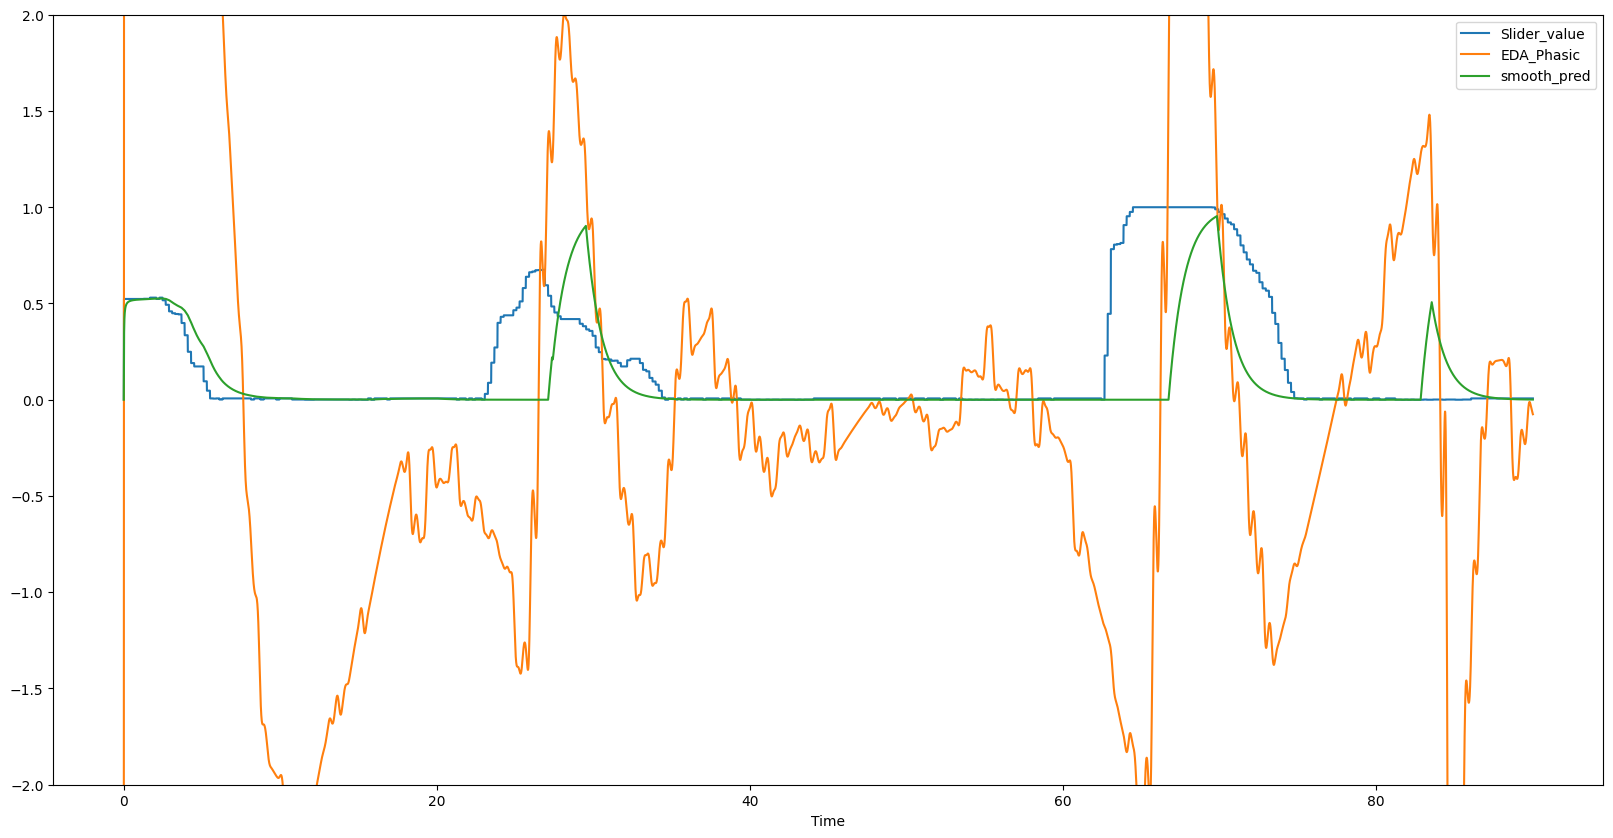

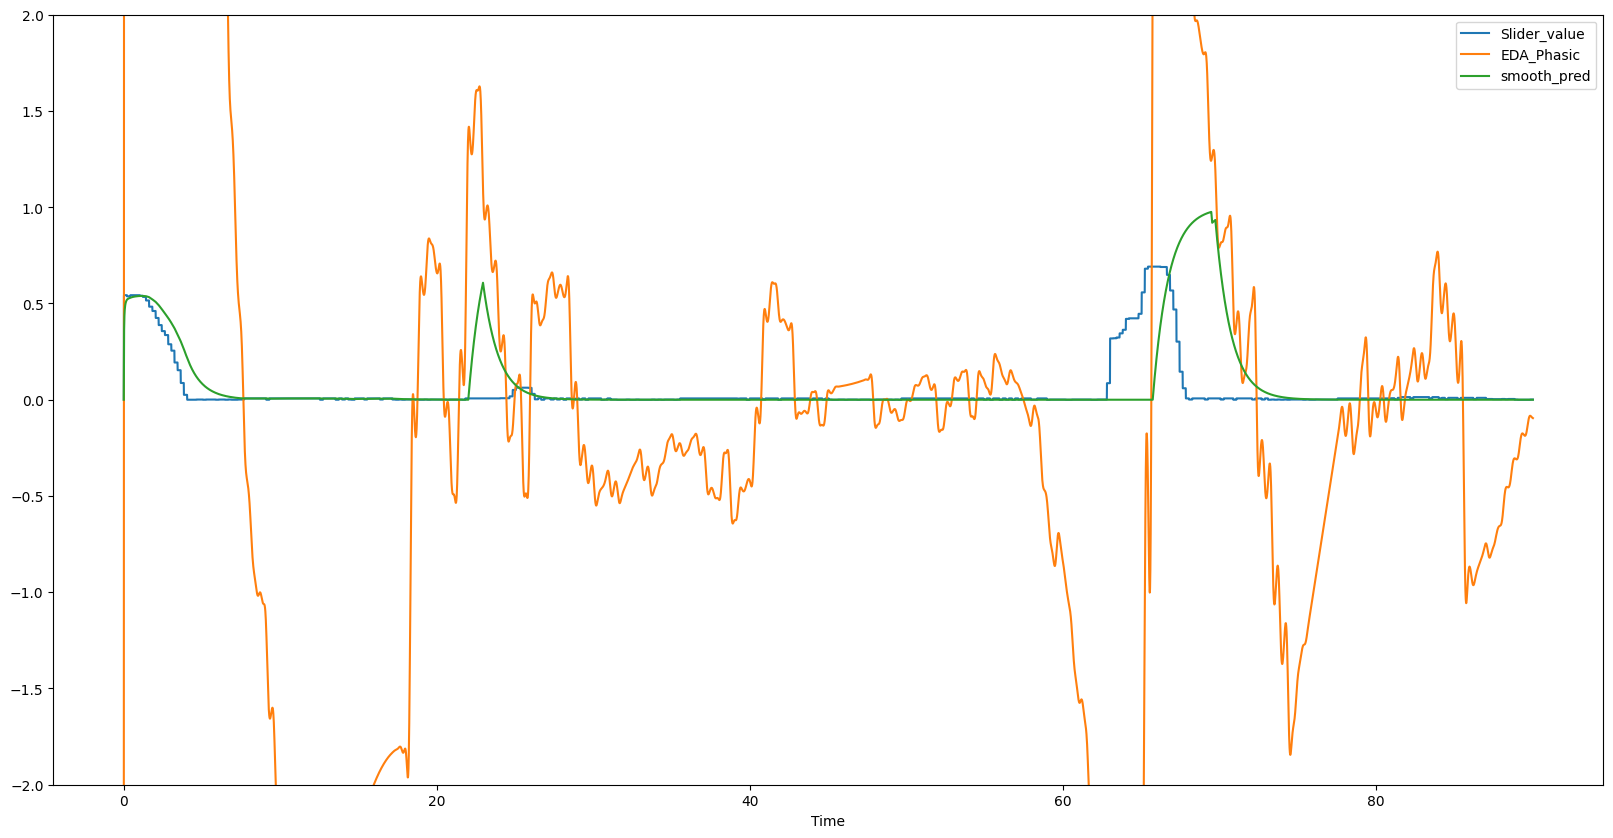

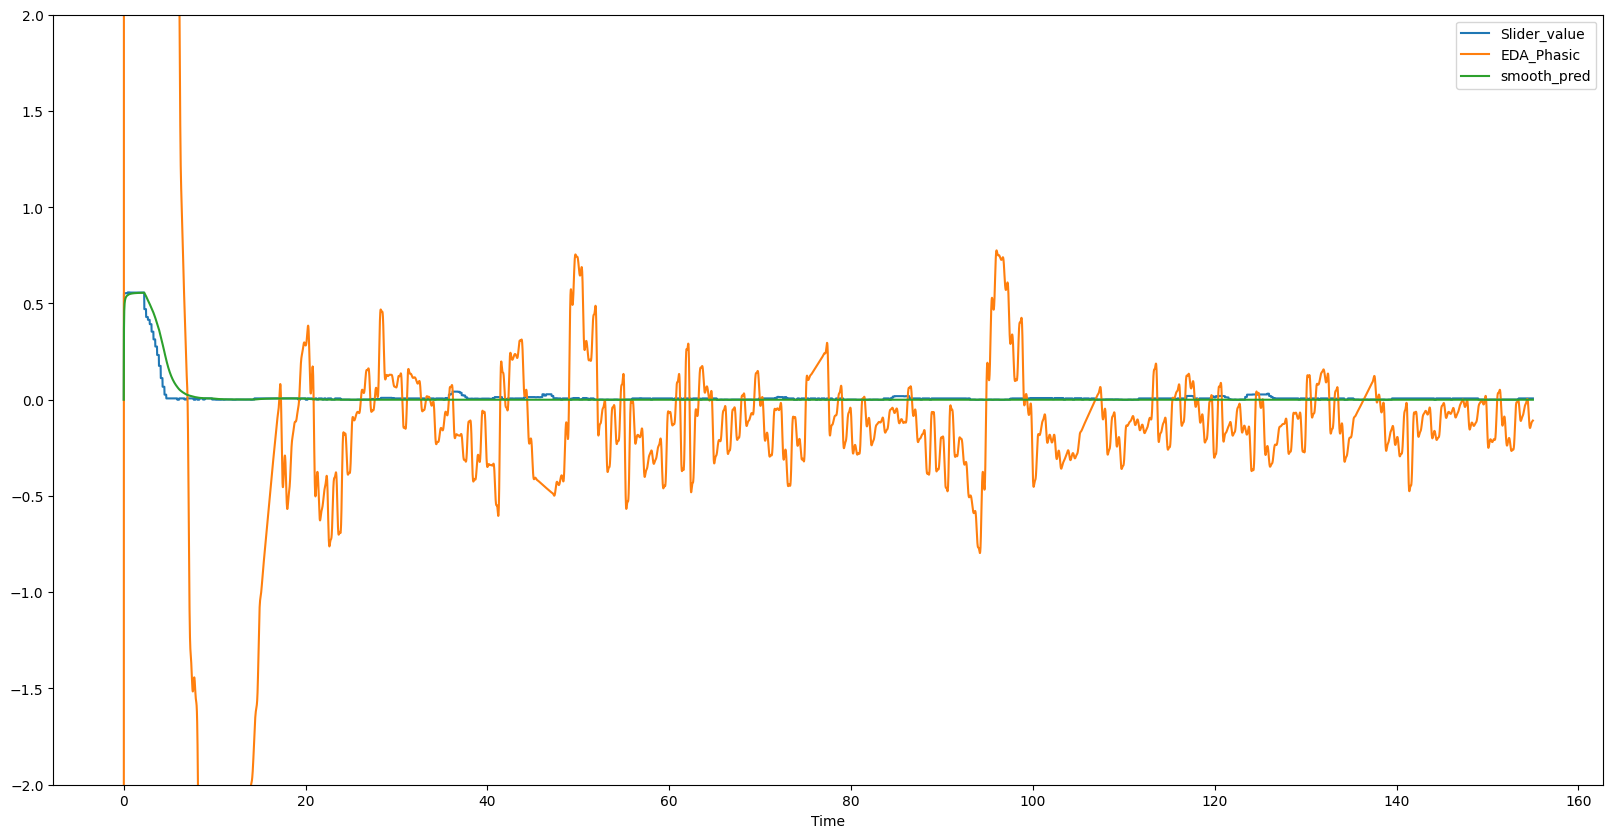

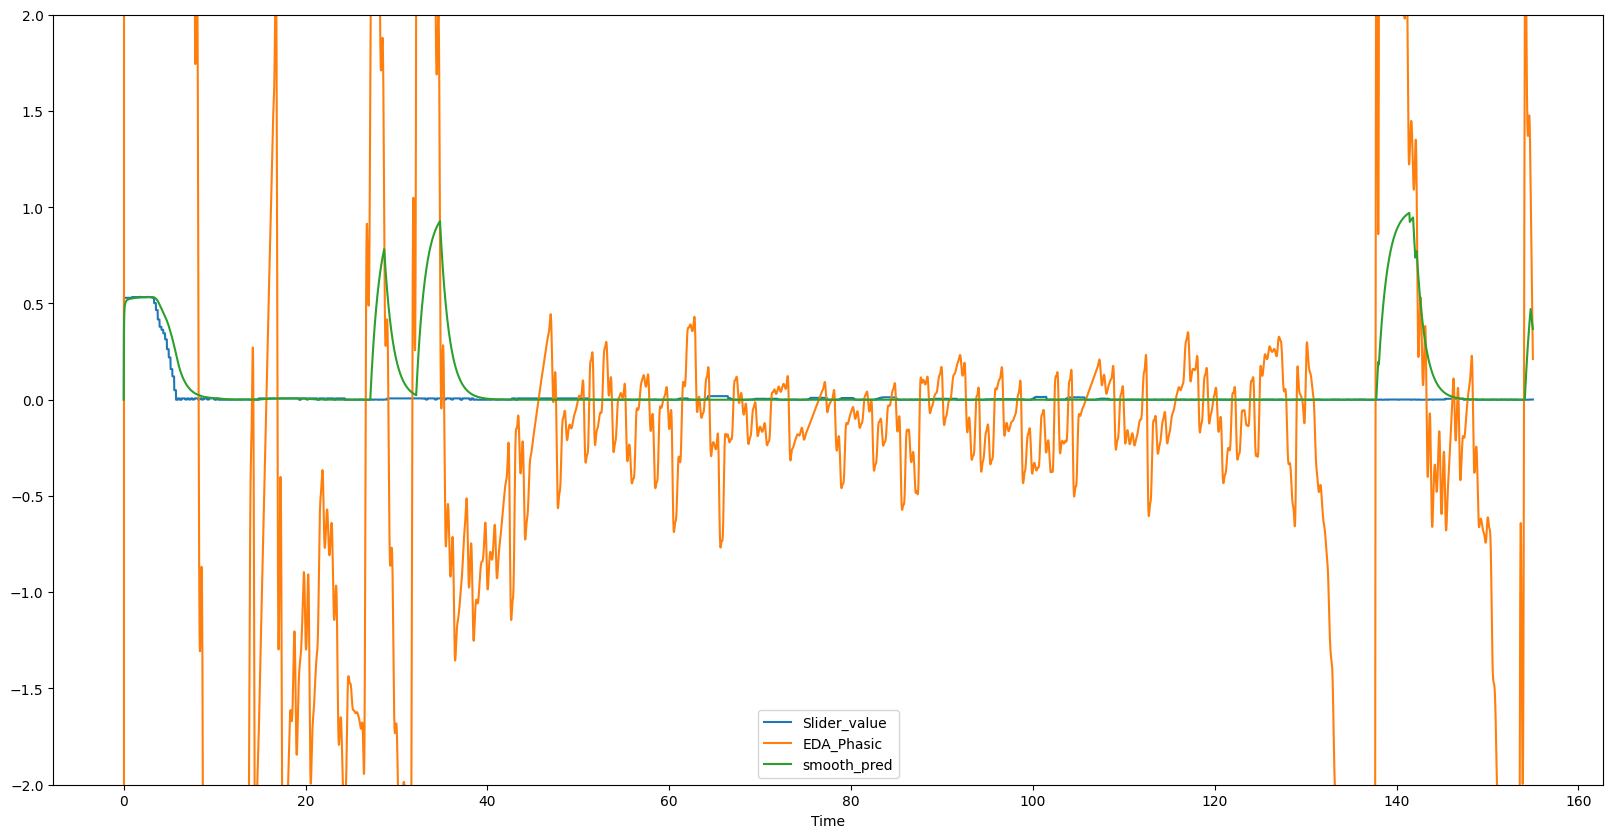

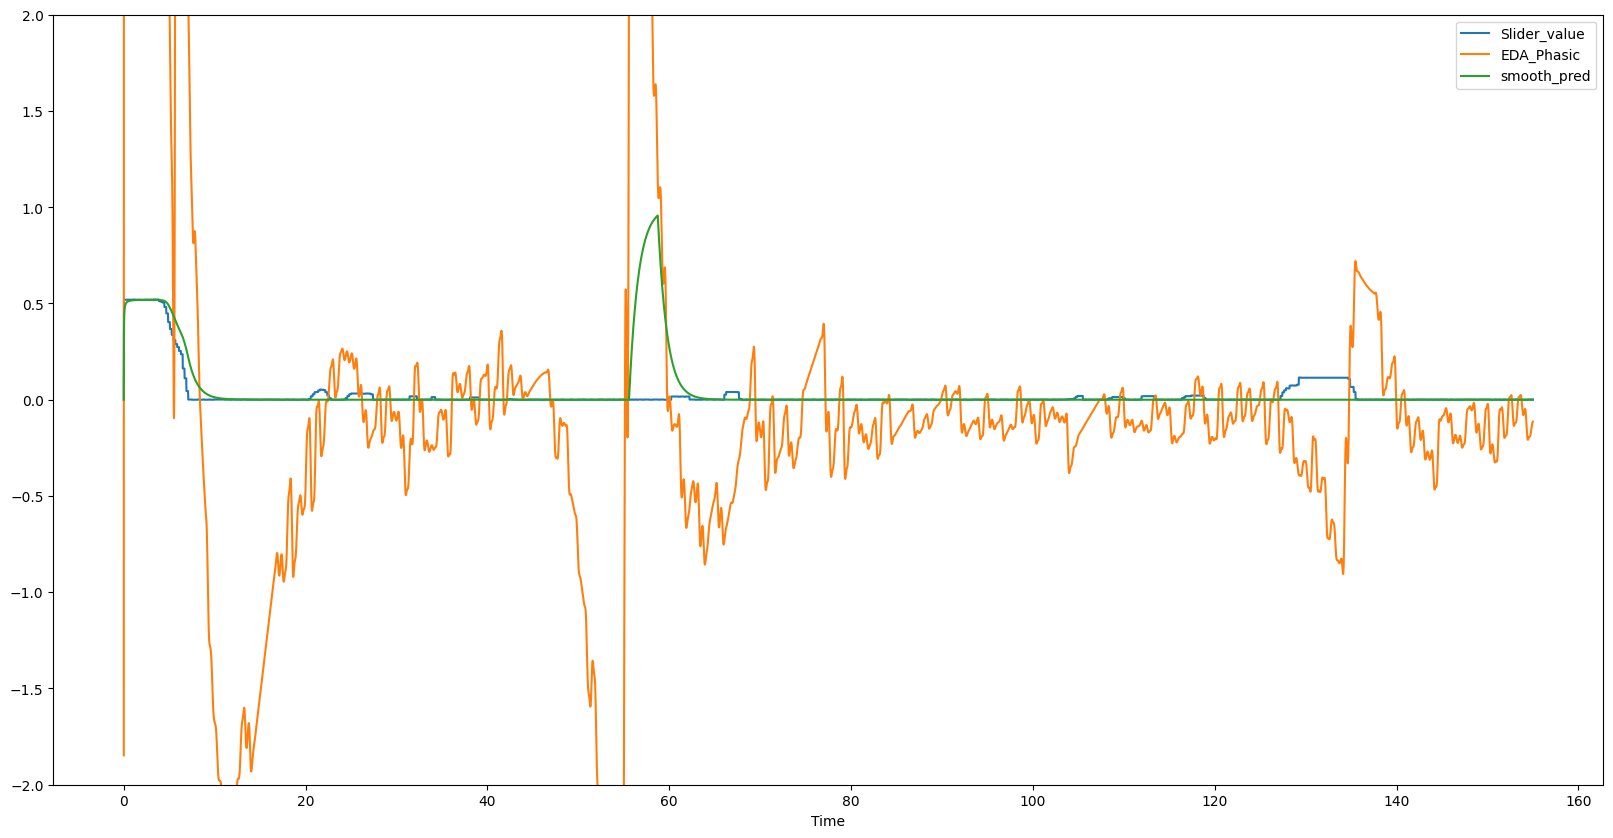

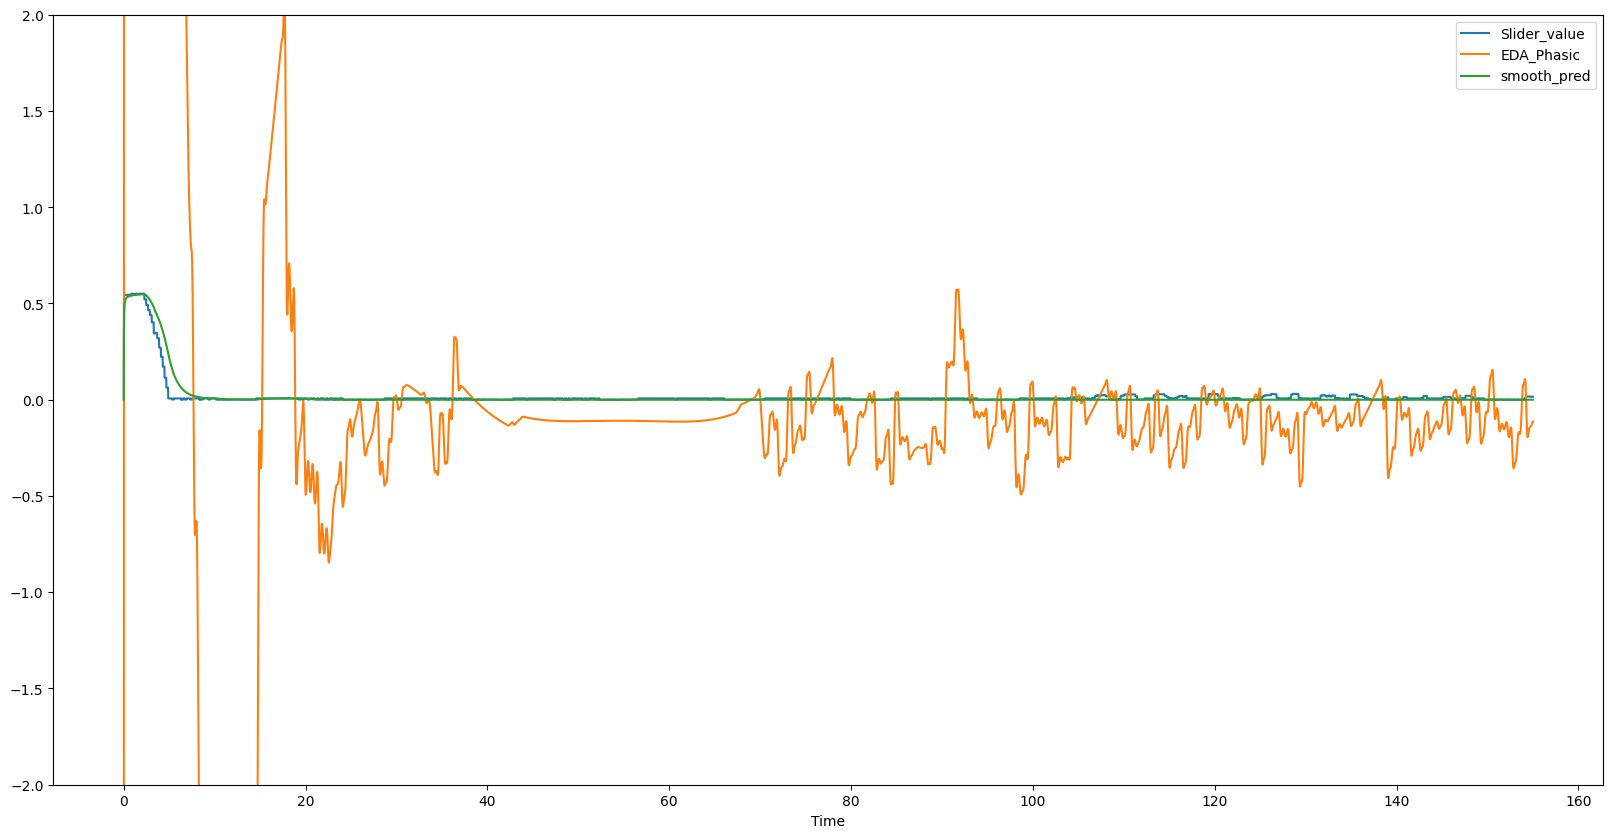

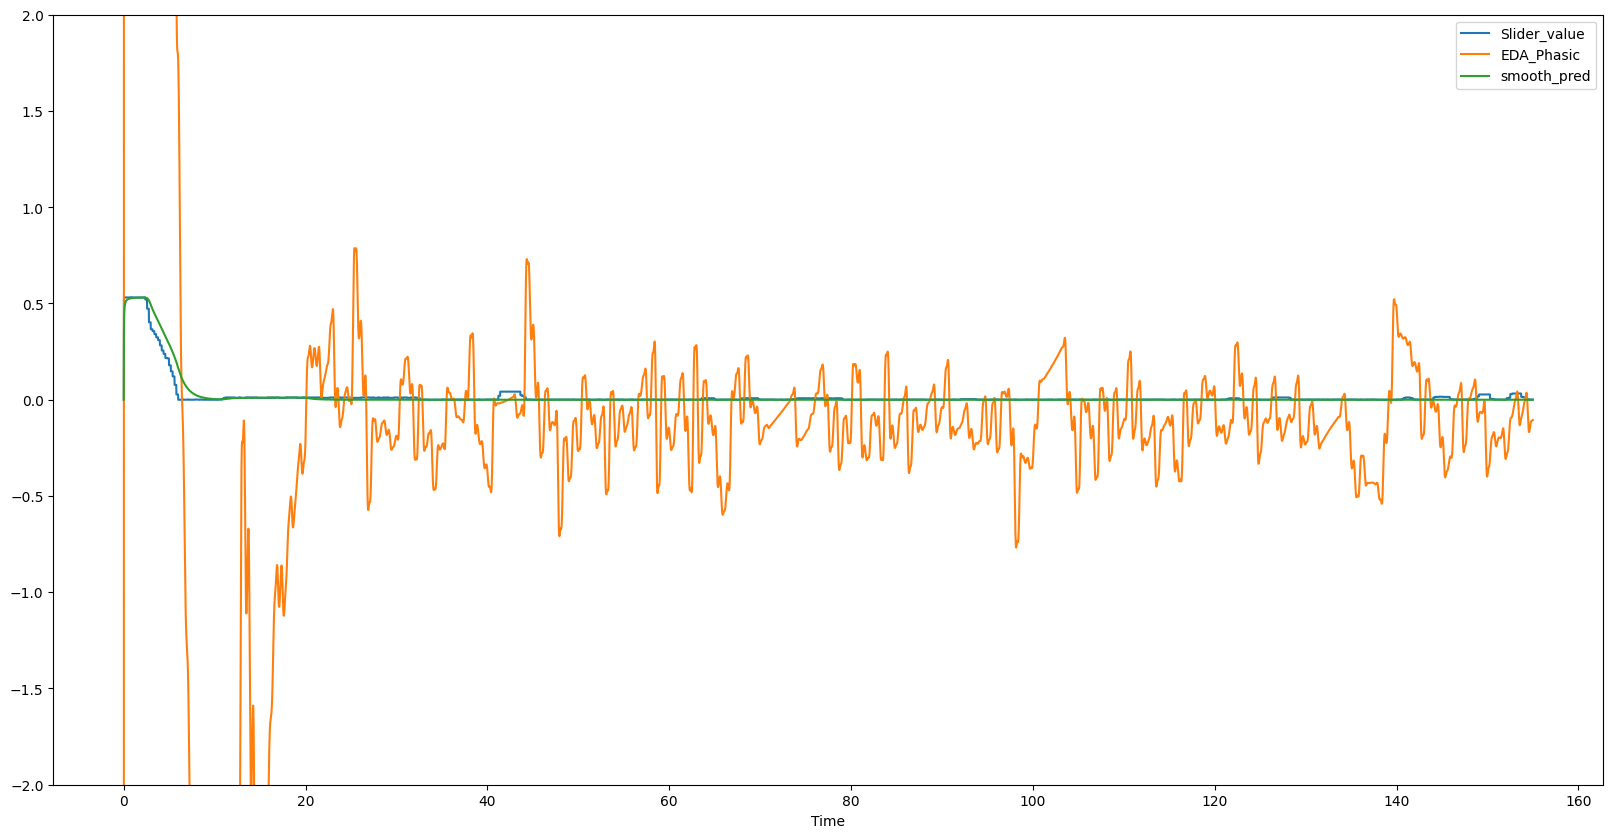

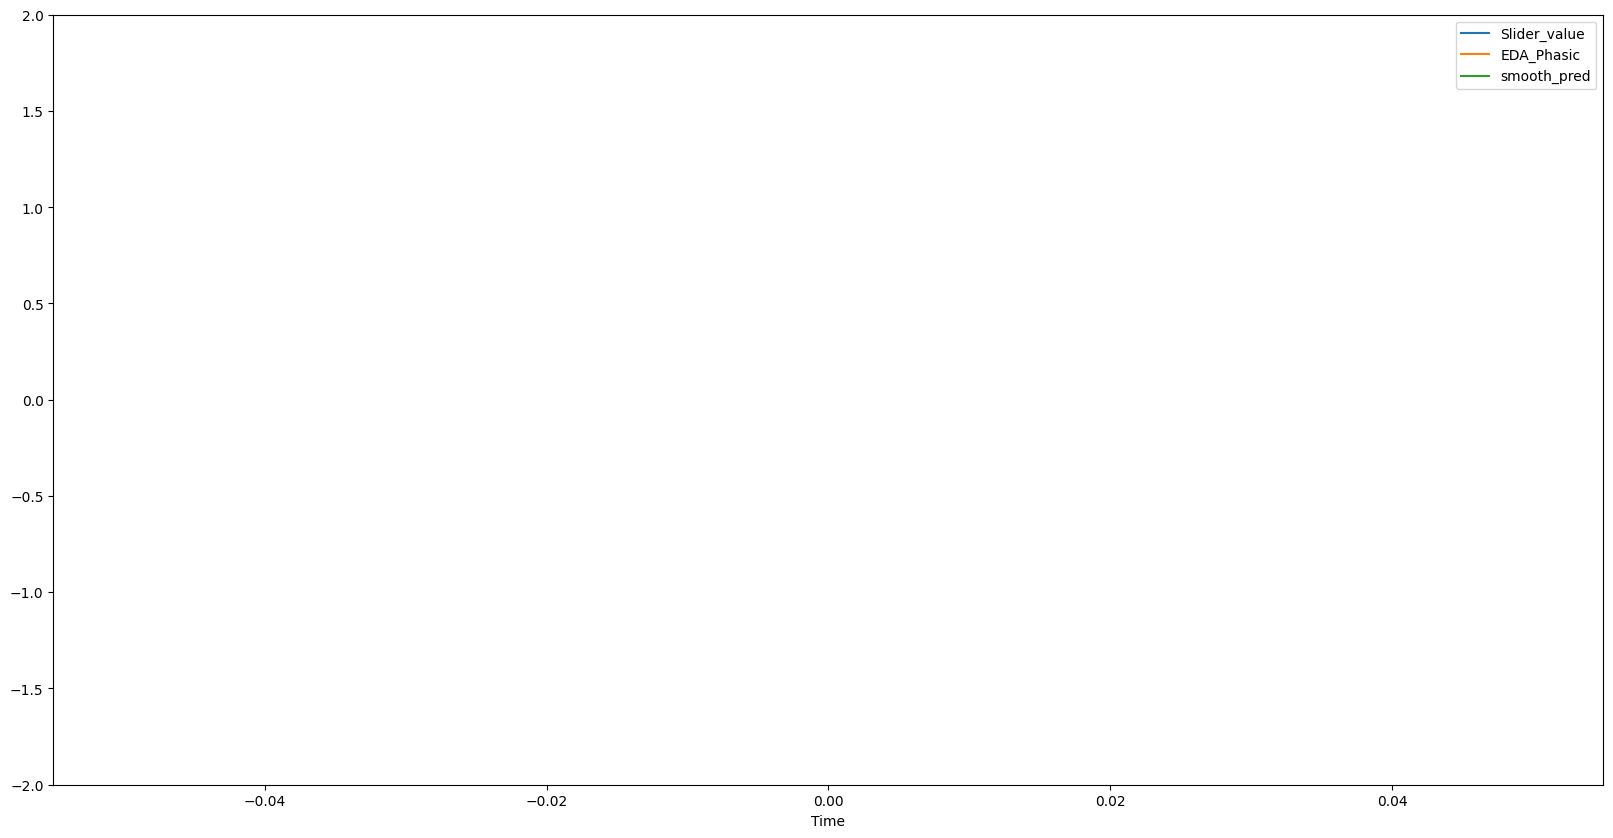

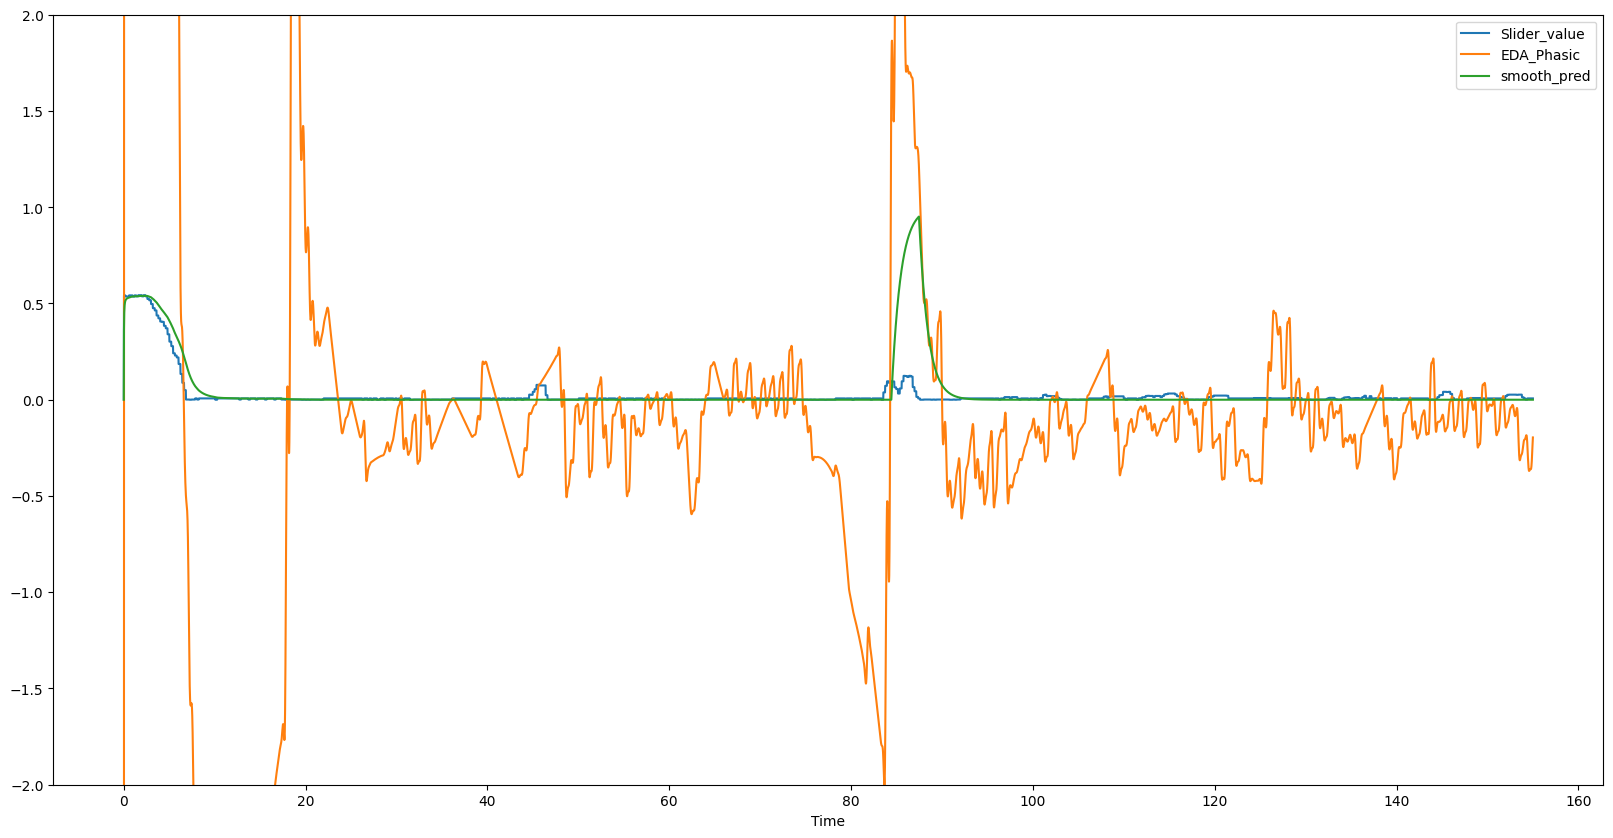

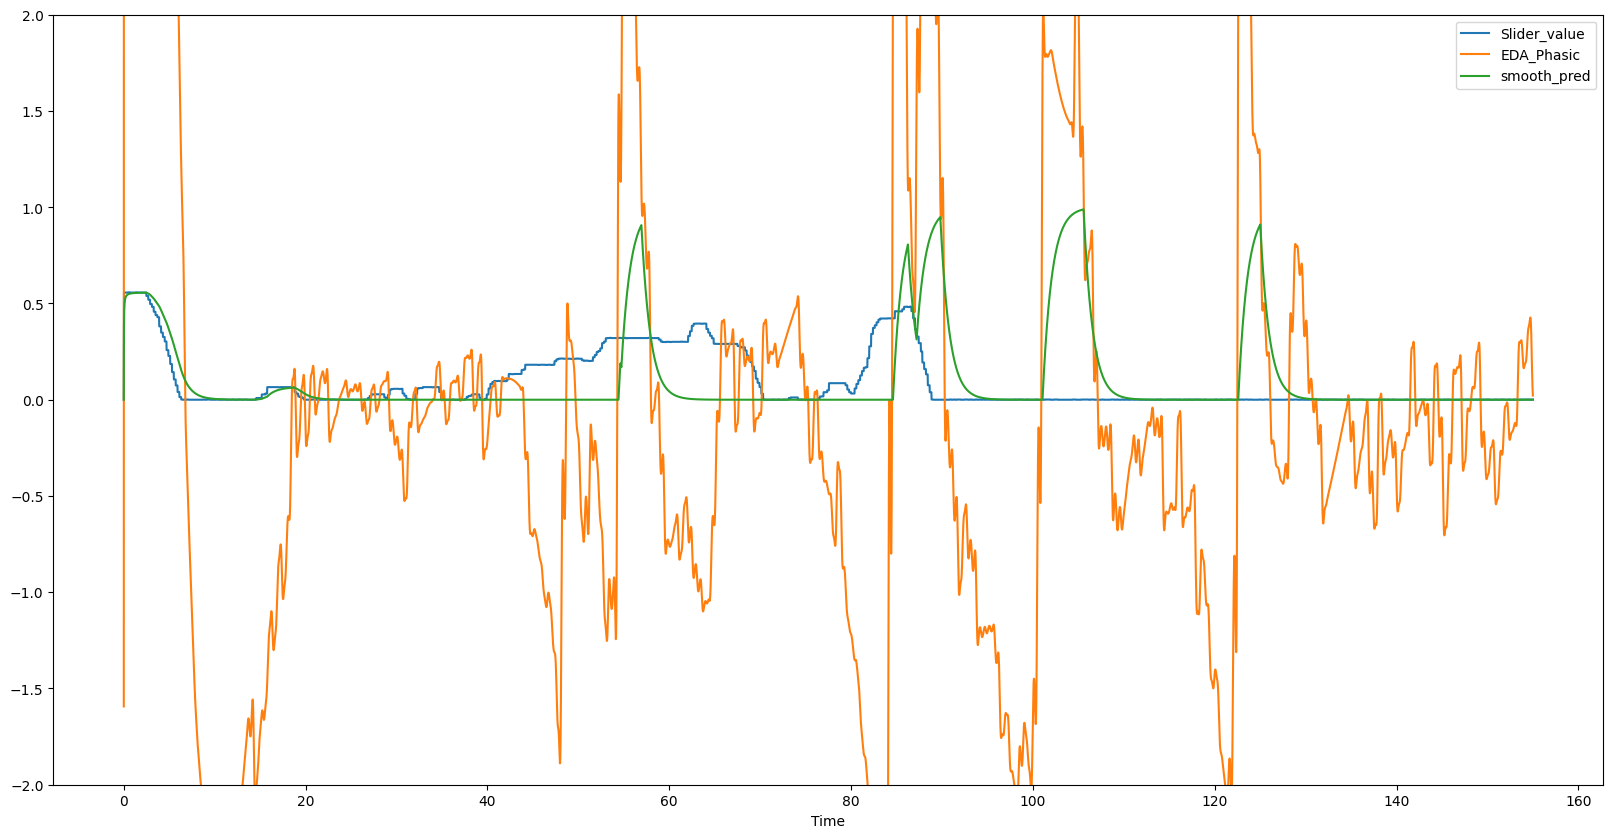

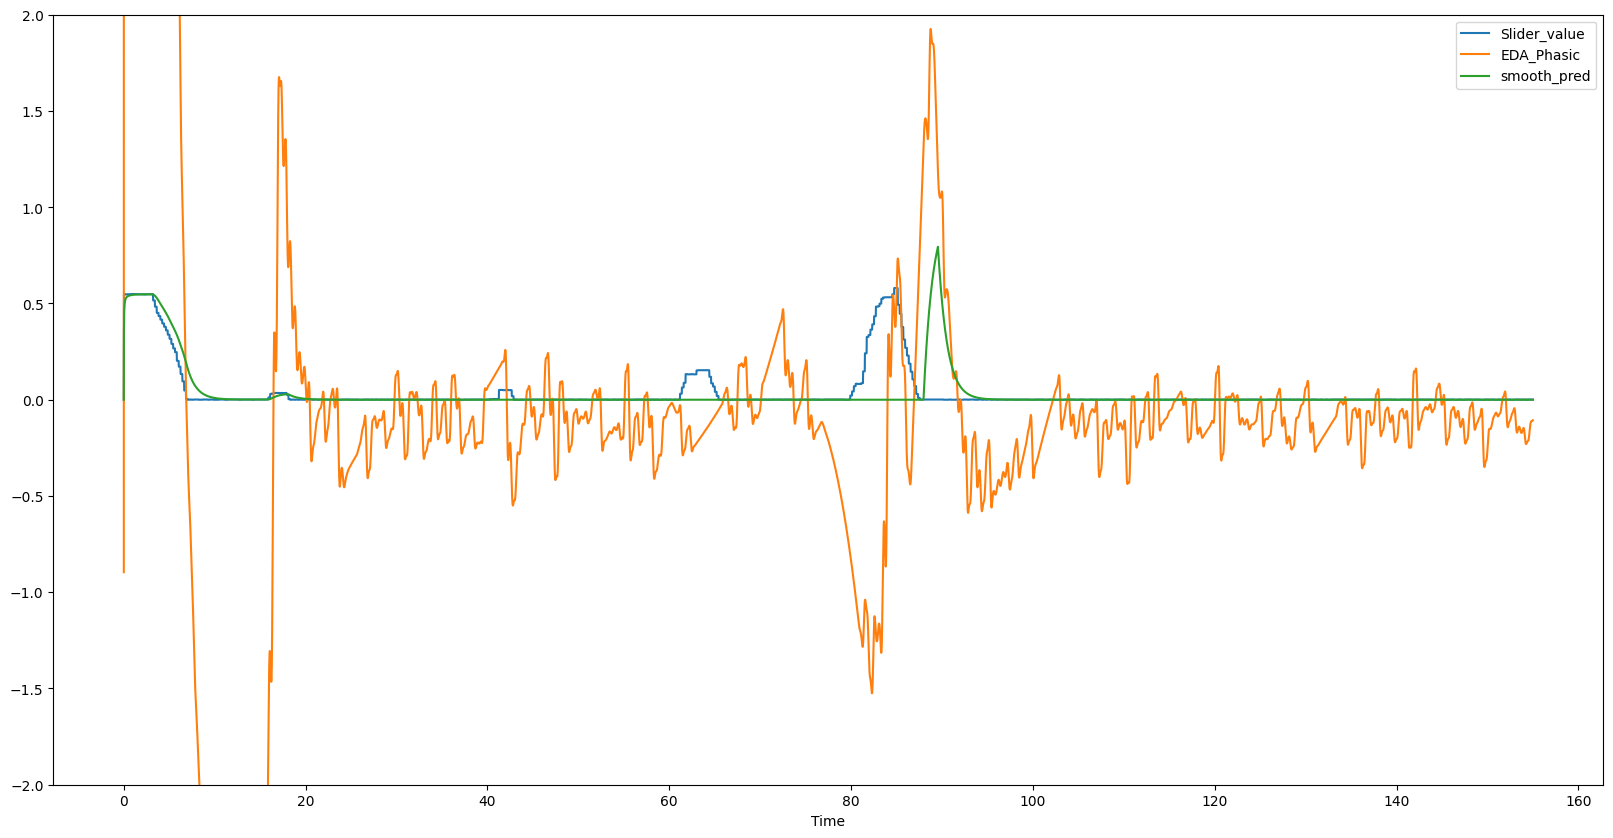

In [4]:
for i in range(1, len(dataset) + 1):
   scenario_df = dataset.features[dataset.features["ScenarioID"] == i].reset_index(drop=True)
   scenario_df["pred"] = scenario_df["EDA_Phasic"].rolling(10).mean().apply(lambda x: 1 if x > 1.25 else 0)
   scenario_df.loc[:2000, "pred"] = scenario_df.loc[:2000, "Slider_value"]
   scenario_df["smooth_pred"] = scenario_df["pred"].ewm(com=100, adjust=True).mean()
   scenario_df.plot(x="Time", y=["Slider_value", "EDA_Phasic", "smooth_pred"], figsize=(20, 10), ylim=(-2, 2))

In [ ]:
sns.kdeplot(data=dataset.features, x="EDA_Phasic", hue="ScenarioID", common_norm=False, alpha=.5)

In [ ]:
baseline.plot(x="Time", y=["Slider_value", "EDA_Clean", "EDA_Phasic"], figsize=(20, 10))

In [ ]:
import seaborn as sns
subj_id = "2038"

bs_path = os.path.join(
    f"/raid/decaro/datasets/processed/AVLStudy/SUBJ_{subj_id}/", f"SUBJ_{subj_id}_SCEN_00_MODE_FreeDriving.csv"
)
baseline = pd.read_csv(bs_path)
baseline["Slider_value"] /= 1024
baseline.iloc[500:].plot(x="Time", y=["Slider_value", "EDA_Clean", "EDA_Tonic", "EDA_Phasic"], figsize=(20, 10))

In [ ]:
dataset = AVLDataset(subj_id, "all", ["EDA_Clean", "EDA_Tonic", "EDA_Phasic"], "baseline", True)
sns.kdeplot(data=abs(baseline[["EDA_Phasic"]]), x="EDA_Phasic", common_norm=False, alpha=.5)

In [ ]:
subj_id = "2038"
scenario_id = 1
dataset = AVLDataset(subj_id, "all",["EDA_Tonic", "EDA_Phasic"], "baseline", False)
df = dataset.features[dataset.features["ScenarioID"] == scenario_id]
# Compute differences with previous row
df["slider_diff"] = df["Slider_value"].diff()
df["slider_diff"].iloc[:2] = df["slider_diff"].iloc[2]
# Compute the rolling sum with a window size of 100
df["slider_diff_rolling_sum"] = df["slider_diff"].rolling(500).sum()
#df = df.iloc[500:]
def to_apply(x):
    if x["slider_diff_rolling_sum"] > 0.05:
        return 1
    elif x["slider_diff_rolling_sum"] < -0.05:
        return 0
    else:
        return np.NaN

df["stressing"] = df.apply(to_apply, axis=1)
df["stressing"].iloc[0] = 0
df["stressing"] = df["stressing"].fillna(method="ffill")

df.plot(x="Time", y=["Slider_value", "stressing", "slider_diff_rolling_sum"], figsize=(20, 10))